# TM10007 Assignment template

In [8]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
##Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
# from worcliver.load_data import load_data
import pandas as pd
#from ecg.load_data import load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# feature space splitsen in labels en features
features = pd.DataFrame(data)
ground_truth = data['label']
features.pop('label')
ground_truth = ground_truth.map(lambda x: 1 if x == 'liposarcoma' else 0)

#features met alleen maar missing data verwijderen
zero_columns = [column for column in features.columns if (features[column] == 0).all()]
features = features.drop(columns=zero_columns)
print(f'The number of features (without missing data features): {len(features.columns)}')

#split data
X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=42)
print(f"Aantal samples in training set: {len(X_train)}")
print(f"Aantal samples in test set: {len(X_test)}")

The number of samples: 115
The number of columns: 494
The number of features (without missing data features): 480
Aantal samples in training set: 92
Aantal samples in test set: 23


In [9]:
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm
# num_cols = X_train.select_dtypes(include=['number']).columns  # Alleen numerieke kolommen
# num_features = len(num_cols)  # Aantal numerieke features
# print(num_features)
# # Instellingen voor het plotten van meerdere histogrammen
# plt.figure(figsize=(15, 12))
# for i, col in enumerate(num_cols[:494]):  # Eerst 20 kolommen om het overzichtelijk te houden
#     plt.subplot(50, 10, i + 1)  # 4 rijen, 5 kolommen per plotpagina
#     sns.histplot(data[col], bins=30, kde=True)
#     # plt.title(col)
#     # plt.xlabel("")
#     # plt.ylabel("Frequentie")

# plt.tight_layout()
# plt.show()

# Controleren voor elke feature of data normaal verdeeld is

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Aantal features normaal verdeeld in beide klassen: 69
Aantal significant verschillende features: 32


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


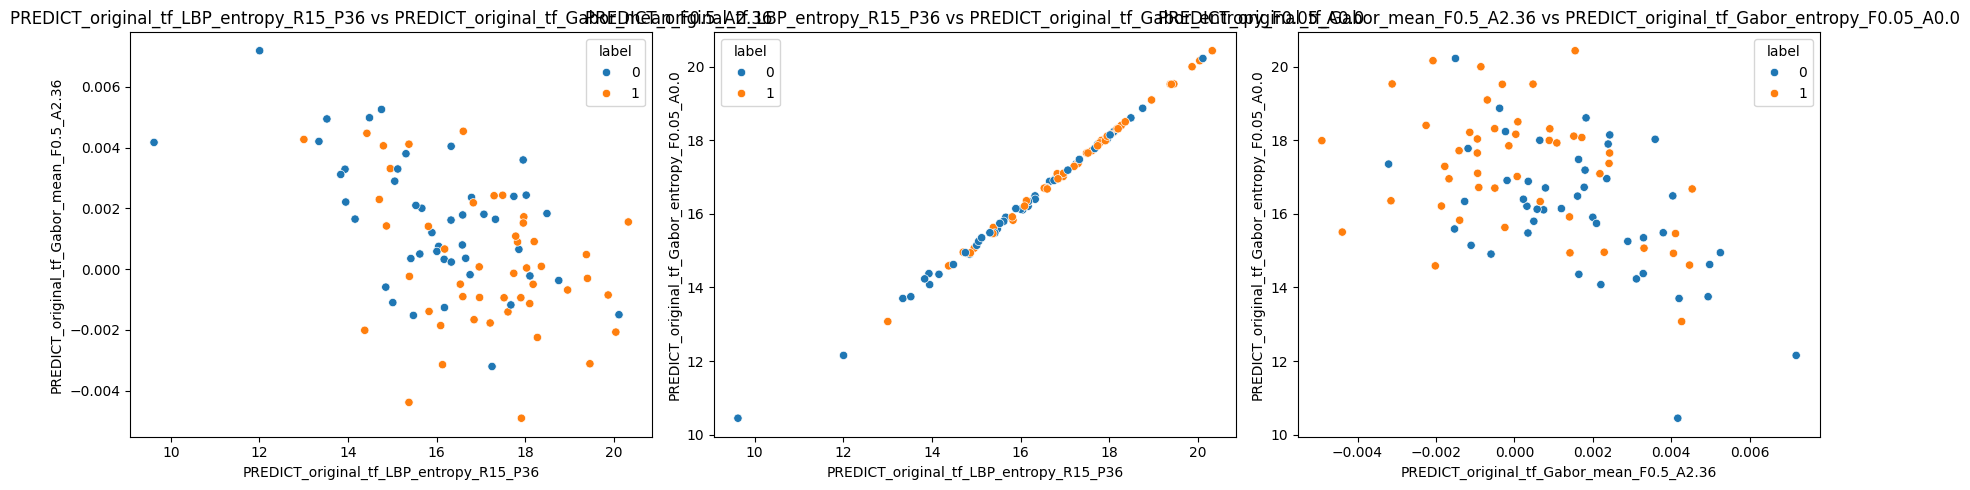

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind

# Shapiro-Wilk test voor normaliteit per feature
normal_features = []
for col in X_train.columns:
    class_0 = X_train[col][y_train == 0]
    class_1 = X_train[col][y_train == 1]

    p_0 = shapiro(class_0)[1]  # p-waarde klasse 0
    p_1 = shapiro(class_1)[1]  # p-waarde klasse 1

    if p_0 > 0.05 and p_1 > 0.05:
        normal_features.append(col)

print(f"Aantal features normaal verdeeld in beide klassen: {len(normal_features)}")

# t-test om significante verschillen te vinden
significant_features = []
alpha = 0.05

for col in normal_features:
    class_0 = X_train[col][y_train == 0]
    class_1 = X_train[col][y_train == 1]

    stat, p = ttest_ind(class_0, class_1, equal_var=False)

    if p < alpha:
        significant_features.append((col, p))

# Sorteer features op p-waarde (laagste eerst)
significant_features.sort(key=lambda x: x[1])

print(f"Aantal significant verschillende features: {len(significant_features)}")


# Minimaal 3 features nodig voor scatterplots
if len(significant_features) >= 3:
    feature_1, feature_2, feature_3 = [f[0] for f in significant_features[:9:3]]

    # Maak scatterplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.scatterplot(x=X_train[feature_1], y=X_train[feature_2], hue=y_train, ax=axes[0])
    axes[0].set_title(f'{feature_1} vs {feature_2}')

    sns.scatterplot(x=X_train[feature_1], y=X_train[feature_3], hue=y_train, ax=axes[1])
    axes[1].set_title(f'{feature_1} vs {feature_3}')

    sns.scatterplot(x=X_train[feature_2], y=X_train[feature_3], hue=y_train, ax=axes[2])
    axes[2].set_title(f'{feature_2} vs {feature_3}')

    plt.tight_layout()
    plt.show()
else:
    print("Niet genoeg significante features om scatterplots te maken.")



# Scalen van feature data

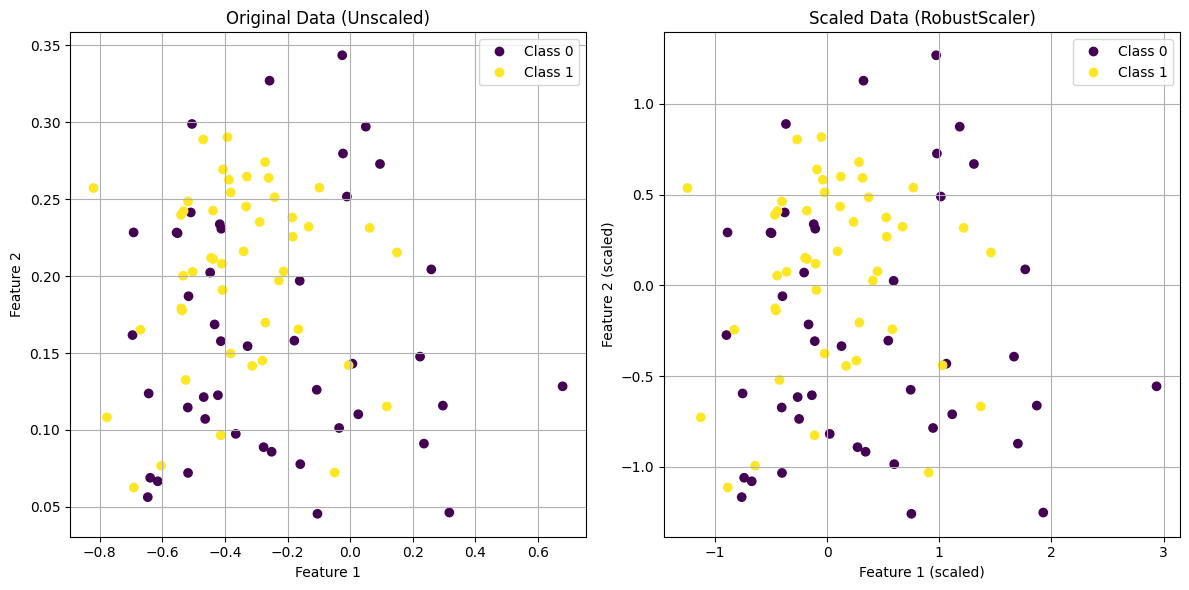

In [10]:
# scaling
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# #scaling plotten op de eerste twee features
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Eerste subplot
scatter = plt.scatter(X_train.iloc[:, 80], X_train.iloc[:, 1], c=y_train, label='Original data') #let op, deze plot is anders doordat je een dataframe hebt
plt.title('Original Data (Unscaled)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True)

plt.subplot(1, 2, 2)  # Tweede subplot
scatter = plt.scatter(X_train_scaled[:, 80], X_train_scaled[:, 1], c=y_train, label='Scaled data') #hier heb je te maken met numpy arrays
plt.title('Scaled Data (RobustScaler)')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature selectie

## Backwards

In [ ]:
# feature selectie
svc = svm.SVC(kernel = 'linear')
rfecv = feature_selection.RFECV(
    estimator=svc, step=1,
    cv=model_selection.StratifiedKFold(8),
    scoring='accuracy')
rfecv.fit(X_train_scaled, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.show()
selected_features = np.where(rfecv.support_)[0]
print("Geselecteerde features:", selected_features)


## Principal component analysis

In [ ]:
## Finding ID's with missing feature values
zero_value_feature = {}
for id in features.index:
    if (features.loc[id] == 0).any():
        zero_columns = features.columns[features.loc[id] == 0].tolist()  # Find columns where value is 0
        zero_value_feature[id] = zero_columns
    else:
        continue

# Random Forest


Top 50 Feature Ranking:
1. Feature 19 (Score: 0.033099)
2. Feature 17 (Score: 0.021569)
3. Feature 312 (Score: 0.019049)
4. Feature 20 (Score: 0.014602)
5. Feature 260 (Score: 0.011696)
6. Feature 325 (Score: 0.010297)
7. Feature 11 (Score: 0.009807)
8. Feature 440 (Score: 0.009590)
9. Feature 377 (Score: 0.009372)
10. Feature 70 (Score: 0.009362)
11. Feature 103 (Score: 0.008321)
12. Feature 208 (Score: 0.008123)
13. Feature 449 (Score: 0.007974)
14. Feature 335 (Score: 0.007443)
15. Feature 205 (Score: 0.007312)
16. Feature 48 (Score: 0.006900)
17. Feature 189 (Score: 0.006873)
18. Feature 16 (Score: 0.006744)
19. Feature 47 (Score: 0.006666)
20. Feature 444 (Score: 0.006642)
21. Feature 422 (Score: 0.006584)
22. Feature 117 (Score: 0.006190)
23. Feature 426 (Score: 0.006156)
24. Feature 372 (Score: 0.006142)
25. Feature 166 (Score: 0.006133)
26. Feature 219 (Score: 0.005955)
27. Feature 387 (Score: 0.005828)
28. Feature 80 (Score: 0.005815)
29. Feature 391 (Score: 0.005756)
30. Feat

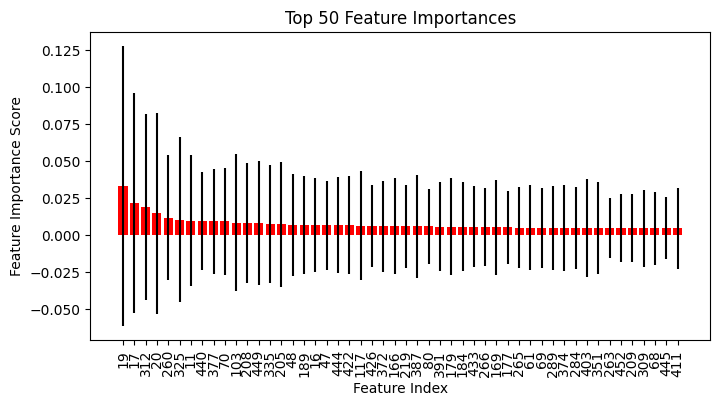

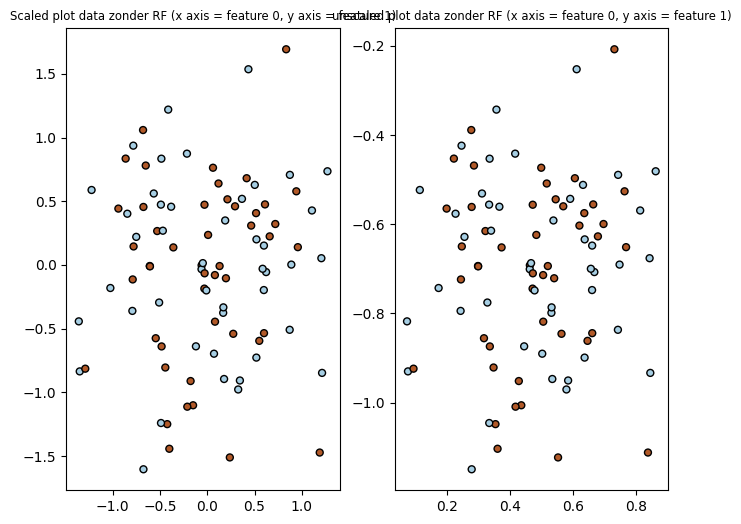

In [14]:
# Train Random Forest
forest = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators is hoeveelheid trees, hierin verschillende proberen
forest.fit(X_train_scaled, y_train)

# Feature importances
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

top_n = min(50, X_train.shape[1])
print("Top 50 Feature Ranking:")
for f in range(top_n):
    print(f"{f + 1}. Feature {indices[f]} (Score: {importances[indices[f]]:.6f})")

# Plot top 50 features gesorteerd op meest belangrijk (links)
plt.figure(figsize=(8, 4))
plt.title("Top 50 Feature Importances")
plt.bar(range(top_n), importances[indices[:top_n]], color="r", yerr=std[indices[:top_n]], align="center")
plt.xticks(range(top_n), indices[:top_n], rotation=90)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance Score")
plt.show()

## normale plot data zonder RF
# Plot 131 scaled data, features 0 en 1
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(131)
ax.set_title("Scaled plot data zonder RF (x axis = feature 0, y axis = feature 1)", fontsize='small')
ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 50], marker='o', c=y_train,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
# Plot 132 unscaled data, features 0 en 1
ax = fig.add_subplot(132)
ax.set_title("unscaled plot data zonder RF (x axis = feature 0, y axis = feature 1)", fontsize='small')
ax.scatter(X_train.values[:, 0], X_train.values[:, 50], marker='o', c=y_train,
            s=25, edgecolor='k', cmap=plt.cm.Paired)




Text(0.5, 1.0, 'Misclassified: 0 / 92')

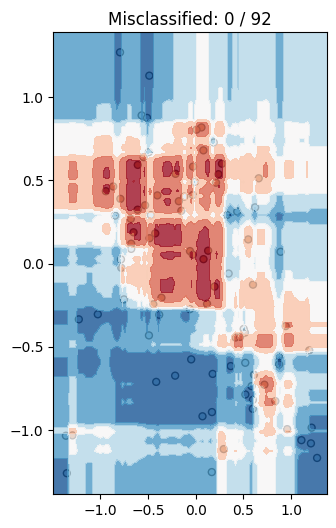

In [21]:
## plotje maken van data met RF eroverheen, zonder tweaken

# RF doen over 2 features. anders werkt de plot niet omdat de forest over alle 500 features is getraind
forest_2d = RandomForestClassifier(n_estimators=100, random_state=42)
forest_2d.fit(X_train_scaled[:, [0, 1]], y_train)  # Train op alleen feature 0 en 1


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(131)
ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], marker='o', c=y_train, s=25, edgecolor='k', cmap=plt.cm.Paired)
colorplot(forest_2d, ax, X_train_scaled[:, 0], X_train_scaled[:, 1])  # Gebruik de nieuwe classifier
y_pred = forest.predict(X_train_scaled)
t = ("Misclassified: %d / %d" % ((y_train != y_pred).sum(), X_train_scaled.shape[0]))
ax.set_title(t)


[-3.31881795e+06  6.15355329e+04  6.15350735e+04 -1.54485060e+06
  5.32267476e+02  6.15352085e+04  6.15349206e+04 -1.26419237e+05
  6.15350878e+04  6.15355206e+04  6.15352379e+04  6.15350519e+04
  6.15350673e+04  6.15350535e+04  5.67432338e+06  6.15349076e+04
  6.15354797e+04  6.15350694e+04  4.95081349e+04  6.15350627e+04
  6.15349961e+04  6.15350696e+04  6.15350814e+04  6.15351182e+04
  6.15350673e+04  6.15350645e+04 -3.11116396e+06  6.15350613e+04
  6.15351293e+04  6.15350756e+04  6.15350786e+04  6.01009146e+04
  6.15350788e+04  6.15350702e+04  6.14681574e+04  6.15351003e+04
  6.15322290e+04  6.15350625e+04  6.15348809e+04  6.15352853e+04
  6.15351089e+04  2.05868948e+03 -4.24236081e+06  6.15350661e+04
  6.15351298e+04  6.14443146e+04  6.15350234e+04  6.15350805e+04
  6.15350706e+04 -1.46529418e+06  6.15356100e+04  6.15351070e+04
  6.15350572e+04  6.15351302e+04  6.15351258e+04  6.15350696e+04
  6.15346790e+04  6.15350633e+04  6.15350638e+04  6.15349518e+04
  6.15350019e+04  6.15350